<a href="https://colab.research.google.com/github/senorred/IDS-Data-Challenges/blob/master/Norred_Liz_Cliff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Customer Cliff Data Challenge
Liz Norred, DS.Sea 20a

####Summary:

####Methods:

####Results:

####Takeaways:

##Set up Google Drive, Import Libraries



---




In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns

##Import Data

Using the parse dates function in pandas' read_csv, I import the datasets as dataframes with all time values in datetime format. I use pandas profiling to run EDA plots on the data. Right away, it appears that user creation has been increasing consistently for the entire time period, so it is unlikely that engagement dropoff is due to a lack of new signups.

In [38]:
users = pd.read_csv('/gdrive/My Drive/Insight Data Science/Data Challenges/yammer_users.csv', header = 0, index_col='user_id', parse_dates=['created_at','activated_at'],infer_datetime_format=True)
print(users.shape)
ProfileReport(users)

(19066, 5)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,5
Number of observations,19066
Total Missing (%),10.2%
Total size in memory,893.7 KiB
Average record size in memory,48.0 B
Numeric,1
Categorical,2
Boolean,0
Date,2
Text (Unique),0
Rejected,0


The users dataframe reveals an interesting use of the "user_id" number-- earlier signups have lower values. So by looking at the frequency of events by user_id in the events dataframe, I can see that user numbers between 12500 and 15000 (signup between about May-July of 2014) have more events per user than later users. This may indicate that these users activity was not sustained long after account creation. This does indicate that users who created their accounts after about July create lower overall events on average. 

In [39]:
events = pd.read_csv('/gdrive/My Drive/Insight Data Science/Data Challenges/yammer_events.csv', header = 0, index_col='user_id',parse_dates=['occurred_at'],infer_datetime_format=True)
print(events.shape)
ProfileReport(events)

(340832, 6)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,7
Number of observations,340832
Total Missing (%),0.7%
Total size in memory,18.2 MiB
Average record size in memory,56.0 B
Numeric,2
Categorical,4
Boolean,0
Date,1
Text (Unique),0
Rejected,0


Similarly, the frequency of email events drops dramatically for newer users. This gives a strong hint that a decrease in email event frequency may be contemporaneous with the decrease in engagement. 

In [40]:
emails = pd.read_csv('/gdrive/My Drive/Insight Data Science/Data Challenges/yammer_emails.csv', header = 0, index_col='user_id', parse_dates=['occurred_at'],infer_datetime_format=True)
print(emails.shape)
ProfileReport(emails)

(90389, 3)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,4
Number of observations,90389
Total Missing (%),0.0%
Total size in memory,2.8 MiB
Average record size in memory,32.0 B
Numeric,2
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,0


In [41]:
rollup = pd.read_csv('/gdrive/My Drive/Insight Data Science/Data Challenges/dimension_rollup_periods.csv', header = 0, index_col='period_id',parse_dates=['time_id','pst_start','pst_end','utc_start','utc_end'],infer_datetime_format=True)
print(rollup.shape)
ProfileReport(rollup)

(56002, 5)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,6
Number of observations,56002
Total Missing (%),0.0%
Total size in memory,2.6 MiB
Average record size in memory,48.0 B
Numeric,1
Categorical,0
Boolean,0
Date,5
Text (Unique),0
Rejected,0


##List Hypotheses

From the frequency data from events and emails, I suspect that a decrease in email event activity may correspond with a decrease in engagment. I'm going to explore the email event activity timescale data, by event.

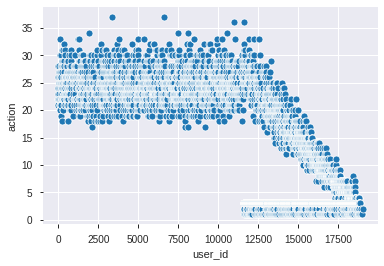

In [62]:
%matplotlib inline
data= emails.groupby(level=0).count()
sns.scatterplot(x= data.index, y=data['action'])

Well, here's one problem: the email events for users after about user 11000 (sometime in May) start dropping precipitously. With some users having little to no events occur at all. That's not great. Maybe these users aren't getting any emails. 

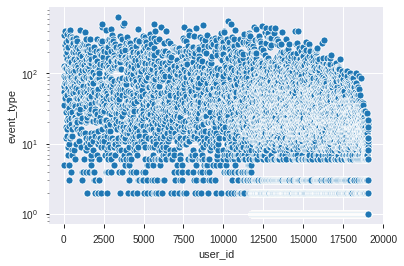

In [67]:
data= events.groupby(level=0).count()
ax= sns.scatterplot(x= data.index, y=data['event_type'])
ax.set_yscale('log')

We can also see that a similar drop in engagement happens around the same time, with many users having little to no engagement after the same date. This happens despite an increase in users over the same time period. 

##Analysis